# Test online filtering algorithm using a difference equation

Enables on the fly filtering of large datasets e.g. numerical model output

See: https://www.dsprelated.com/freebooks/filters/Difference_Equation_I.html
    
Difference equation is:

$$
y_n = \sum_{i=0}^{M} b_i x_{n-i} - \sum_{j=1}^{N} a_j y_{n-j}
$$

where $x_n$ is the discrete input data and $y_n$ is the filtered data.

In [154]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from glob import glob

from netCDF4 import Dataset
from soda.dataio.suntans.suntans_ugrid import ugrid


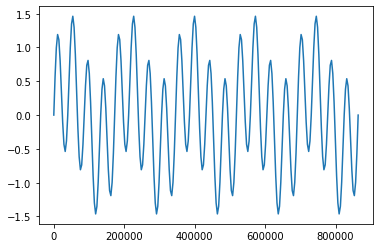

In [14]:
# Create a test time series with two dominant frequencies (use the filter to remove one)
dt = 3600.
tmax = 10*86400

T1 = 12*3600
T2 = 48*3600.
a1 = 1.
a2 = 0.5

t = np.arange(0,tmax+dt,dt)

x = a1*np.sin(2*np.pi/T1*t) + a2*np.sin(2*np.pi/T2*t)

plt.figure()
plt.plot(t,x)

In [15]:
# Design a butterworth filter
order = 3
# Wn = 1/(30*3600)
# (b,a) = signal.butter(order, Wn, fs=1/dt)
Wn = dt/(30*3600)
(b,a) = signal.butter(order, Wn, fs=1)
b,a

(array([0.00094131, 0.00282394, 0.00282394, 0.00094131]),
 array([ 1.        , -2.58186143,  2.24666664, -0.6572747 ]))

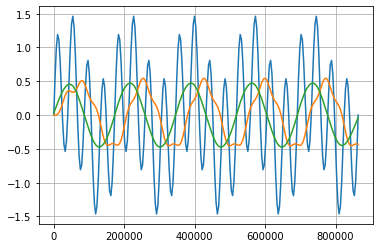

In [16]:
y_true = signal.lfilter(b,a, x)
y_ff = signal.filtfilt(b,a, x)


plt.figure()
plt.plot(t,x)
plt.plot(t,y_true)
plt.plot(t,y_ff)
plt.grid(b=True)

In [17]:
def load_next(ii):
    #placeholder function to load next input
    return x[ii,...]

# Online filtering algorithm
nt = x.shape[0]
P = order
x_tmp = np.zeros((P+1,)+x.shape[1:])
y_tmp = np.zeros((P+1,)+x.shape[1:])

# Load up the initial values of x_tmp and y_tmp
x_tmp[:,...] = x[0:P+1, ...]
#y_tmp[:,...] = x[0:P+1]

# Create an output array for testing
y_filt = np.zeros((nt,))
#y_filt[0:P+1] = y_tmp

for ii in range(P, nt):
    # shuffle everything back in x and y
    x_tmp[1:P+1,...] = x_tmp[0:P,...]
    y_tmp[1:P+1,...] = y_tmp[0:P,...]
    
    # Load new data step
    x_tmp[0,...] = load_next(ii)
    
    y_tmp[0,...] = 0.
    for n in range(0,P+1):
        y_tmp[0,...] += b[n]*x_tmp[n,...]
        
    for j in range(1,P+1):
        y_tmp[0,...] -= a[j]*y_tmp[j,...]
    
    #print(y_tmp[0],x_tmp[0])
    # output
    y_filt[ii,...] = y_tmp[0,...]


In [82]:
class OnlineFilter(object):
    """
    Online filtering class
    """
    def __init__(self, dt, cutoff_dt, P, shape, loadfunc):
        """
        Inputs:
            dt - data sampling rate
            cutoff_dt - cutoff time step
            P - filter order
            shape - array shape not including the time dimension
            loadfunc - function to load a chunk of data
                should take an index as input and return an array of size (1, shape)
        """
        self.P=P
        self.dt = dt
        self.cutoff_dt = cutoff_dt
        self.shape = shape
        self.loadfunc = loadfunc
        
        # Compute the filter coefficients
        Wn = dt/cutoff_dt
        (b,a) = signal.butter(P, Wn, fs=1)
        self.b, self.a = b, a
        
        # Initialize the filtering arrays
        self.x_tmp = np.zeros((self.P+1,)+self.shape)
        self.y_tmp = np.zeros((self.P+1,)+self.shape)

        # Load up the initial values of x_tmp 
        self._ii = 0
        for nn in range(0, self.P):
            self.x_tmp[nn,...] = loadfunc(self._ii)
            self._ii+=1
        
        # Initialise y_tmp with the mean
        self.y_tmp[:,...] = self.x_tmp[0:self.P,...].mean(axis=0)

    def __call__(self):
        """
        Apply the filter to the next value
        """
        P = self.P
        # shuffle everything back in x and y
        self.x_tmp[1:P+1,...] = self.x_tmp[0:P,...]
        self.y_tmp[1:P+1,...] = self.y_tmp[0:P,...]

        # Load new data step
        self.x_tmp[0,...] = self.loadfunc(self._ii)
        
        # Zero the first step
        self.y_tmp[0,...] = 0.
        
        for n in range(0,P+1):
            self.y_tmp[0,...] += self.b[n]*self.x_tmp[n,...]

        for j in range(1,P+1):
            self.y_tmp[0,...] -= self.a[j]*self.y_tmp[j,...]
            
        self._ii += 1
        
        return self.y_tmp[0,...]


In [83]:
y_filt = np.zeros((nt,))
#y_filt[0:P+1] = y_tmp

F = OnlineFilter(dt, 30*3600, 3, (), load_next)
for ii in range(P, nt):
    y_filt[ii] = F()

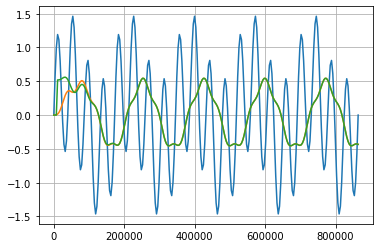

In [84]:
plt.figure()
plt.plot(t,x)
plt.plot(t,y_true)
plt.plot(t,y_filt)
plt.grid(b=True)

In [116]:
# Test on some suntans data

In [1]:
from soda.dataio.suntans.sunpy import Grid, Spatial



Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


In [138]:
# testfile = [
#     '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data1/NWS_2km_GLORYS_hex_20130701.nc.97',
#     '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data2/NWS_2km_GLORYS_hex_20130801.nc.97'
# ]

testfile = []
fn = 97
for ii in range(1,13):
    testfile.append(
        glob( '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data{}/NWS_2km_GLORYS_hex_*.nc.{}'.\
            format(ii,fn))[0]
    )

#testfile
sun = Spatial(testfile, _FillValue=999999, klayer=[-99])

Loading: ['../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data1/NWS_2km_GLORYS_hex_20130701.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data2/NWS_2km_GLORYS_hex_20130801.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data3/NWS_2km_GLORYS_hex_20130901.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data4/NWS_2km_GLORYS_hex_20131001.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data5/NWS_2km_GLORYS_hex_20131101.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data6/NWS_2km_GLORYS_hex_20131201.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data7/NWS_2km_GLORYS_hex_20140101.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data8/NWS_2km_GLORYS_hex_20140201.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data9/NWS_2km_GLORYS_hex_20140301.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data10/NWS_2km_GLORYS_hex_20140401.nc.97', '../SCENARIOS/NWS_2km_GLORYS_hex_Nk80dt60_2013_20

In [139]:
sun.tstep=0
rho=sun.loadData(variable='rho')
rho.shape, sun.Nkmax,sun.Nc, sun.time.shape

((80, 919), 80, 919, (8772,))

In [140]:
def load_rho(ii):
    sun.tstep = [ii]
    #print(ii)
    return sun.loadData(variable='rho')*1000+1000.
    

In [112]:
rho_surf_low = np.zeros((sun.Nt-1, shape[1]))
rho_surf = np.zeros((sun.Nt-1, shape[1]))

kk = 15
rho_surf[0:P,...] = F.x_tmp[0:P,kk,:]
rho_surf_low[0:P,...] = F.y_tmp[0:P,kk,:]

for ii in range(P, sun.Nt-1):
    rho_low = F()
    rho_surf_low[ii,...] = rho_low[kk,:]
    rho_surf[ii,...] = F.x_tmp[0,kk,:]


(1024, 1027)

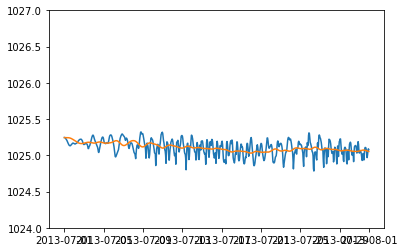

In [113]:
plt.figure()
plt.plot(sun.time[0:-1], rho_surf[:,0])
plt.plot(sun.time[0:-1], rho_surf_low[:,0])
plt.ylim(1024,1027)

In [142]:
def calc_ssh(rho, rholow, dz, rho0=1024., g=9.81, axis=0):
    rhopr = rho-rho_low
    b = -rhopr*g/rho0
    
    p_surf = rho0* np.sum(b*dz[:,None], axis=axis)
    
    return p_surf / (rho0*g)


F = OnlineFilter(dt, 60*3600, P, shape, load_rho)

ssh_bc = np.zeros((sun.Nt,sun.Nc))
for ii in range(P, sun.Nt-1):
    if ii%100 == 0:
        print(ii,sun.Nt)
    rho_low = F()
    rho = F.x_tmp[0,:,:]
    
    ssh_bc[ii,:] = calc_ssh(rho,rho_low, sun.dz)
    
rho.shape, rho_low.shape

100 8772
200 8772
300 8772
400 8772
500 8772
600 8772
700 8772
800 8772
900 8772
1000 8772
1100 8772
1200 8772
1300 8772
1400 8772
1500 8772
1600 8772
1700 8772
1800 8772
1900 8772
2000 8772
2100 8772
2200 8772
2300 8772
2400 8772
2500 8772
2600 8772
2700 8772
2800 8772
2900 8772
3000 8772
3100 8772
3200 8772
3300 8772
3400 8772
3500 8772
3600 8772
3700 8772
3800 8772
3900 8772
4000 8772
4100 8772
4200 8772
4300 8772
4400 8772
4500 8772
4600 8772
4700 8772
4800 8772
4900 8772
5000 8772
5100 8772
5200 8772
5300 8772
5400 8772
5500 8772
5600 8772
5700 8772
5800 8772
5900 8772
6000 8772
6100 8772
6200 8772
6300 8772
6400 8772
6500 8772
6600 8772
6700 8772
6800 8772
6900 8772
7000 8772
7100 8772
7200 8772
7300 8772
7400 8772
7500 8772
7600 8772
7700 8772
7800 8772
7900 8772
8000 8772
8100 8772
8200 8772
8300 8772
8400 8772
8500 8772
8600 8772
8700 8772


((80, 919), (80, 919))

(array([735050., 735112., 735173., 735234., 735293., 735354., 735415.]),
 <a list of 7 Text xticklabel objects>)

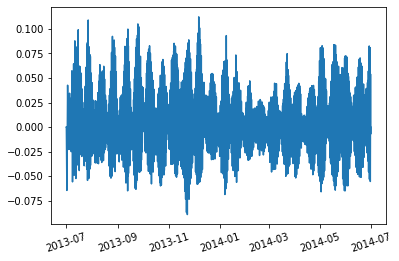

In [160]:
plt.figure()
plt.plot(sun.time, ssh_bc[:,505])
plt.xticks(rotation=18)

In [147]:
outfile = '../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_GLORYS_hex_2013_2014_SSHBC.nc.{}'.format(fn)
print(outfile)

../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_GLORYS_hex_2013_2014_SSHBC.nc.97


In [159]:
#
# Create the output file 
sun.Nk = np.zeros((sun.Nc,),dtype=np.int32)
#sun.dv = np.ones((sun.Nc,),dtype=np.int32)
sun.Nkmax = 1
sun.z_r = 0.
sun.z_w = [0,1.]
sun.dz = 0.

print(sun.dv.max())

sun.writeNC(outfile)

# Create the output variables
dims = ('time', 'Nc')
attrs = {'ssh_bc':\
        {'long_name':'baroclinic sea surface height anomaly',\
        'coordinates':'time Nc',\
        'units':'m'},\
    }

varlist = ['ssh_bc']
for vv in varlist:
    print('Creating variable: %s'%vv)
    sun.create_nc_var(outfile, vv,\
        dims,\
        attrs[vv],\
    )

sun.create_nc_var(outfile,'time',\
    ugrid['time']['dimensions'],\
    ugrid['time']['attributes'])

# Create the solution
#T = np.arange(tlim[0],tlim[1]+dt,dt)
T = sun.timeraw
nt = T.shape[0]

nc = Dataset(outfile,'a')

## Do it in one hit
nc.variables['time'][:] = T 
sun.tstep = range(0,nt)

vv = 'ssh_bc'
print('Saving variable %s...'%vv)
nc.variables[vv][:] = ssh_bc
nc.close()
print('Done. Save to file: ', outfile)


5901.676624
Writing variables: xp
Writing variables: yp
Writing variables: xv
Writing variables: yv
Writing variables: xe
Writing variables: ye
Writing variables: lonv
Writing variables: latv
Writing variables: lonp
Writing variables: latp
Writing variables: cells
Writing variables: face
Writing variables: nfaces
Writing variables: edges
Writing variables: neigh
Writing variables: grad
Writing variables: mark
Writing variables: normal
Writing variables: mnptr
Writing variables: eptr
Writing variables: n1
Writing variables: n2
Writing variables: df
Writing variables: dg
Writing variables: def
Writing variables: Ac
Writing variables: dv
Writing variables: dz
Writing variables: z_r
Writing variables: z_w
Writing variables: Nk
Writing variables: Nke
Creating variable: ssh_bc
Saving variable ssh_bc...
Done. Save to file:  ../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_GLORYS_hex_2013_2014_SSHBC.nc.97


In [158]:
nc.close()